In [1]:
# -*- pecanns -*-
"""
Author: Shamsulhaq Basir
Date  : July 20, 2022
"""
import argparse
import time
import os
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

from torch.optim import LBFGS,Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float64)
dtype  = torch.float64

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import matplotlib as mpl
from matplotlib import ticker

# for reproducibility of the result
torch.manual_seed(123)
# https://pytorch.org/docs/stable/notes/randomness.html
# Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. 
# Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is :", device)

device is : cpu


In [2]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net = nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 
    def forward(self, x):
        out = self.net(x)
        return out 
    
    
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu    = kwargs["mean"]
        self.stdev = kwargs["stdev"]
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x,t):
        data = torch.cat((x,t),dim=1);
        # normalize the input
        data = (data - self.mu)/self.stdev
        out  = self.net(data)
        u    = out[:,0].reshape(-1,1)
        v    = out[:,1].reshape(-1,1)
        p    = out[:,2].reshape(-1,1)
        w    = out[:,3].reshape(-1,1)
        return u,v,p,w
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)   

In [3]:
def pde_opt(model,x,y):
    u,v,p,w = model(x,y)
    
    fx      = force_x(x,y)
    fy      = force_y(x,y)
    
    px,py   = torch.autograd.grad(p.sum(),(x,y),create_graph=True)
    wx,wy   = torch.autograd.grad(w.sum(),(x,y),create_graph=True)
    ux,uy   = torch.autograd.grad(u.sum(),(x,y),create_graph=True)
    vx,vy   = torch.autograd.grad(v.sum(),(x,y),create_graph=True)
    
    physics_loss    = ( px + wy - fx).pow(2) +  (py - wx - fy).pow(2)
    divergence_loss = (ux + vy).pow(2)
    vorticity_loss  = (w + uy - vx).pow(2)
    return physics_loss,divergence_loss,vorticity_loss

In [4]:
def top_boundary_opt(model,x,y):
    u,_,p,_   = model(x,y)
    u_res_top = (u).pow(2)
    pe        = p_exact(x,y)
    p_res_top = (p - pe).pow(2)
    
    return u_res_top,p_res_top

def right_boundary_opt(model,x,y):
    u,v,_,_ = model(x,y)
    u_res_right = (u).pow(2)
    v_res_right = (v).pow(2)
    return u_res_right,v_res_right

def bottom_boundary_opt(model,x,y):
    u,v,_,_ = model(x,y)
    u_res_bottom = (u).pow(2)
    v_res_bottom = (v).pow(2)
    return u_res_bottom,v_res_bottom

def left_boundary_opt(model,x,y):
    u,v,_,_ = model(x,y)
    u_res_left = (u).pow(2)
    v_res_left = (v).pow(2)
    return u_res_left,v_res_left


In [5]:
def u_exact(x,y):
    return x**2*(1. - x)**2*(4.*y**3 - 6.*y**2 + 2.*y)

In [6]:
def v_exact(x,y):
    return y**2*(1. - y)**2*(-4.*x**3 + 6.*x**2 - 2.*x)

In [7]:
def p_exact(x,y):
    return x**2 - y**2

In [8]:
def w_exact(x,y):
    return -x**2*(1 - x)**2*(12*y**2 - 12*y + 2) + y**2*(1 - y)**2*(-12*x**2 + 12*x - 2)

In [9]:
def force_x(x,y):
    fx = -1.0*x**2*(1 - x)**2*(24*y - 12) +\
        2*x + 1.0*y**2*(2*y - 2)*(-12*x**2 + 12*x - 2) +\
        2.0*y*(1 - y)**2*(-12*x**2 + 12*x - 2)
    return fx

In [10]:
def force_y(x,y):
    fy = 1.0*x**2*(2*x - 2)*(12*y**2 - 12*y + 2) +\
         2.0*x*(1 - x)**2*(12*y**2 - 12*y + 2) - \
         1.0*y**2*(1 - y)**2*(12 - 24*x) - 2*y
    return fy

In [11]:
def fetch_residual_points(domain,N_data):
    soboleng = torch.quasirandom.SobolEngine(dimension=2,scramble=True)
    data   = soboleng.draw(N_data,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x        = data[:,0][:,None]
    y        = data[:,1][:,None]
    return x,y

In [12]:
# def fetch_residual_points(domain,N_data=32):
#     x_min    = domain[0][0]
#     x_max    = domain[1][0]
    
#     y_min    = domain[0][1]
#     y_max    = domain[1][1]
    
#     x        = torch.linspace(x_min,x_max,N_data)
#     y        = torch.linspace(y_min,y_max,N_data)
    
#     x,y      = torch.meshgrid(x,y,indexing='xy')
#     x        = x.reshape(-1,1)
#     y        = y.reshape(-1,1)
#     return x,y

In [13]:
def fetch_top_boundary(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    x         = soboleng.draw(N_data,dtype=dtype)*(x_max - x_min) + x_min
    y         = torch.full_like(x,y_max)
    return x,y

In [14]:
def fetch_bottom_boundary(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    x         = soboleng.draw(N_data,dtype=dtype)*(x_max - x_min) + x_min
    y         = torch.full_like(x,y_min)
    return x,y

In [15]:
def fetch_right_boundary(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    y        = soboleng.draw(N_data,dtype=dtype)*(y_max - y_min) + y_min
    x        = torch.full_like(y,x_max)
    return x,y

In [16]:
def fetch_left_boundary(domain,N_data):
    """
    Sampling collocation point:
    Args : 
        - domain :(numpy array) for the size of the domain
        - N_data :(int) number of points 
    out : a tensor of collocation points
    """
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    y        = soboleng.draw(N_data,dtype=dtype)*(y_max - y_min) + y_min
    x        = torch.full_like(y,x_min)
    return x,y

In [17]:
domain   = np.array([[0.,0.],[1.0,1.0]])
kwargs ={"mean":torch.tensor([[0.5, 0.5]]), "stdev":torch.tensor([[0.2887, 0.2887]])}   

layers = [2,50,50,50,50,4]
model  = Network(layers,**kwargs)
model.apply(init_weights)

optimizer   = LBFGS(model.parameters(),line_search_fn="strong_wolfe")

print(model)
print(model.mu.shape)
print(model.stdev.shape)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Tanh()
      )
    )
    (4): Linear(in_features=50, out_features=4, bias=True)
  )
)
torch.Size([1, 2])
torch.Size([1, 2])


In [18]:
# sampling collocation points in the domain
x_dm,y_dm  = fetch_residual_points(domain,2048)
x_dm       = x_dm.requires_grad_(True)
y_dm       = y_dm.requires_grad_(True)

# Sampling toplinspacendary conditions
x_tb,y_tb  = fetch_top_boundary(domain,512)

# Sampling right boundary conditions
x_rb,y_rb  = fetch_right_boundary(domain,512)

# Sampling bottom boundary conditions
x_bb,y_bb  = fetch_bottom_boundary(domain,512)

# Sampling left boundary conditions
x_lb,y_lb  = fetch_left_boundary(domain,512)

In [19]:
lambda_vorticity  = torch.ones_like(x_dm)
lambda_divergence = torch.ones_like(x_dm)

lambda_u_tb      = torch.ones_like(x_tb)
lambda_u_rb      = torch.ones_like(x_rb)
lambda_u_bb      = torch.ones_like(x_bb)
lambda_u_lb      = torch.ones_like(x_lb)

lambda_p_tb      = torch.ones_like(x_tb)


lambda_v_rb      = torch.ones_like(x_rb)
lambda_v_bb      = torch.ones_like(x_bb)
lambda_v_lb      = torch.ones_like(x_lb)




vi_vorticity      = torch.zeros_like(x_dm)
vi_divergence     = torch.zeros_like(x_dm)


vi_u_tb          = torch.zeros_like(x_tb)
vi_u_rb          = torch.zeros_like(x_rb)
vi_u_bb          = torch.zeros_like(x_bb)
vi_u_lb          = torch.zeros_like(x_lb)

vi_p_tb          = torch.zeros_like(x_tb)

vi_v_rb          = torch.zeros_like(x_rb)
vi_v_bb          = torch.zeros_like(x_bb)
vi_v_lb          = torch.zeros_like(x_lb)


moment          = 0.9
lr              = 1.0

epochs          = 10000

In [20]:
def evaluate(model,domain):
    x_min    = domain[0][0]
    x_max    = domain[1][0]
    
    y_min    = domain[0][1]
    y_max    = domain[1][1]
    
    x = torch.linspace(x_min,x_max,64)
    y = torch.linspace(y_min,y_max,64)

    x,y = torch.meshgrid(x,y,indexing='ij')

    x_,y_ = x.reshape(-1,1),y.reshape(-1,1)

    pe = p_exact(x,y)
    we = w_exact(x,y)

    u,v,p,w = model(x_,y_)

    p = p.detach().reshape(x.shape)
    w = w.detach().reshape(x.shape)
    
    error_u_relative = np.linalg.norm(p-pe, 2)/np.linalg.norm(pe, 2)
    absolute_error   =(p-pe).abs().max()
    return error_u_relative,absolute_error

In [21]:
for epoch in range(1,epochs+1):

    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        physics_res,divergence_res,vorticity_res = pde_opt(model,x_dm,y_dm)
        
        # divergence loss
        divergence_loss = (lambda_divergence * divergence_res).sum()
        
        
        # vorticity loss
        vorticity_loss  = (lambda_vorticity * vorticity_res).sum()
        
        
        # top boundary loss 
        u_res_top, p_res_top     = top_boundary_opt(model,x_tb,y_tb)
        
        u_top_loss = (lambda_u_tb * u_res_top).sum()
        
        p_top_loss = (lambda_p_tb * p_res_top).sum()
        
        
        # right boundary loss
        u_res_right, v_res_right   = right_boundary_opt(model,x_rb,y_rb)
        
        u_right_loss = (lambda_u_rb * u_res_right).sum()
        
        v_right_loss = (lambda_v_rb * v_res_right).sum()
        
        # bottom boundary loss 
        u_res_bottom, v_res_bottom = bottom_boundary_opt(model,x_bb,y_bb)
        
        u_bottom_loss = (lambda_u_bb * u_res_bottom).sum()
        
        v_bottom_loss = (lambda_v_bb * v_res_bottom).sum()
        
        
        # left boundary loss 
        u_res_left, v_res_left = left_boundary_opt(model,x_lb,y_lb)
        
        u_left_loss = (lambda_u_lb * u_res_left).sum()
        
        v_left_loss = (lambda_v_lb * v_res_left).sum()
        
        
        # total loss
        loss      = physics_res.sum() + divergence_loss  + vorticity_loss +\
                    u_top_loss    + p_top_loss + \
                    u_right_loss  + v_right_loss +\
                    u_bottom_loss + v_bottom_loss +\
                    u_left_loss   + v_left_loss 
            
        if loss.requires_grad:
            loss.backward()
        return loss
    
    
    def _closure():
        physics_res,divergence_res,vorticity_res = pde_opt(model,x_dm,y_dm)
        
        # top boundary loss 
        u_res_top, p_res_top      = top_boundary_opt(model,x_tb,y_tb)
        
        # right boundary loss
        u_res_right, v_res_right   = right_boundary_opt(model,x_rb,y_rb)
        
        # bottom boundary loss 
        u_res_bottom, v_res_bottom = bottom_boundary_opt(model,x_bb,y_bb)
        
        # left boundary loss 
        u_res_left, v_res_left = left_boundary_opt(model,x_lb,y_lb)
    
        residuals = {'divergence_res':divergence_res,
                   'vorticity_res':vorticity_res,
                   'u_res_top':u_res_top,
                   'p_res_top':p_res_top,
                   'u_res_right':u_res_right,
                   'v_res_right':v_res_right,
                   'u_res_bottom':u_res_bottom,
                   'v_res_bottom':v_res_bottom,
                   'u_res_left':u_res_left,
                   'v_res_left':v_res_left
                  }
        return residuals

    optimizer.step(closure)
    residuals = _closure()
    
    with torch.no_grad():
        divergence_res = residuals['divergence_res']
        vorticity_res  = residuals['vorticity_res']
        
        u_res_top      = residuals['u_res_top']
        p_res_top      = residuals['p_res_top']
        
        u_res_right    = residuals['u_res_right']
        v_res_right    = residuals['v_res_right']
        
        u_res_bottom   = residuals['u_res_bottom']
        v_res_bottom   = residuals['v_res_bottom']
        
        u_res_left     = residuals['u_res_left']
        v_res_left     = residuals['v_res_left']

        vi_divergence  = (1.0 - moment) * divergence_res.pow(2) + moment * vi_divergence
        vi_vorticity   = (1.0 - moment) * vorticity_res.pow(2)  + moment * vi_vorticity
        
        
        vi_u_tb        = (1.0 - moment) * u_res_top.pow(2)     + moment * vi_u_tb
        vi_u_rb        = (1.0 - moment) * u_res_right.pow(2)   + moment * vi_u_rb
        vi_u_bb        = (1.0 - moment) * u_res_bottom.pow(2)  + moment * vi_u_bb
        vi_u_lb        = (1.0 - moment) * u_res_left.pow(2)    + moment * vi_u_lb
    
        vi_p_tb        = (1.0 - moment) * p_res_top.pow(2)     + moment * vi_p_tb
        vi_v_rb        = (1.0 - moment) * v_res_right.pow(2)   + moment * vi_v_rb
        vi_v_bb        = (1.0 - moment) * v_res_bottom.pow(2)  + moment * vi_v_bb
        vi_v_lb        = (1.0 - moment) * v_res_left.pow(2)    + moment * vi_v_lb
        
        lambda_divergence    += lr / ( vi_divergence   + 1e-8).sqrt()   * divergence_res
        lambda_vorticity     += lr / ( vi_vorticity    + 1e-8).sqrt()   * vorticity_res
        
        lambda_u_tb          += lr / ( vi_u_tb   + 1e-8).sqrt()   * u_res_top
        lambda_u_rb          += lr / ( vi_u_rb   + 1e-8).sqrt()   * u_res_right
        lambda_u_bb          += lr / ( vi_u_bb   + 1e-8).sqrt()   * u_res_bottom
        lambda_u_lb          += lr / ( vi_u_lb   + 1e-8).sqrt()   * u_res_left

        lambda_p_tb          += lr / ( vi_p_tb   + 1e-8).sqrt()   * p_res_top
        lambda_v_rb          += lr / ( vi_v_rb   + 1e-8).sqrt()   * v_res_right
        lambda_v_bb          += lr / ( vi_v_bb   + 1e-8).sqrt()   * v_res_bottom
        lambda_v_lb          += lr / ( vi_v_lb   + 1e-8).sqrt()   * v_res_left
        
        
        if epoch %1000 == 0 :
            l2,linf  = evaluate(model,domain)
            print(f'epochs :{epoch :5d}, error_u_relative:{l2:2.3e}, absolute error:{linf:2.3e}')

epochs : 1000, error_u_relative:3.273e-03, absolute error:8.225e-03
epochs : 2000, error_u_relative:1.279e-03, absolute error:4.117e-03
epochs : 3000, error_u_relative:1.178e-03, absolute error:3.507e-03
epochs : 4000, error_u_relative:1.178e-03, absolute error:3.507e-03
epochs : 5000, error_u_relative:1.027e-03, absolute error:3.202e-03
epochs : 6000, error_u_relative:9.947e-04, absolute error:3.082e-03
epochs : 7000, error_u_relative:9.947e-04, absolute error:3.082e-03
epochs : 8000, error_u_relative:9.952e-04, absolute error:3.092e-03
epochs : 9000, error_u_relative:9.952e-04, absolute error:3.092e-03
epochs :10000, error_u_relative:9.952e-04, absolute error:3.092e-03


In [22]:
torch.save(model.state_dict(),"models/Stokes_Flow.pt")

In [20]:
model.load_state_dict(torch.load("models/Stokes_Flow.pt"))

<All keys matched successfully>

In [21]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels
    'axes.titlesize': 24,
    'font.size'     : 20, 
    'legend.fontsize': 18, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [4, 4],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

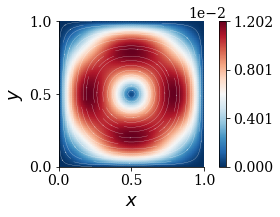

In [27]:
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

x = torch.linspace(0,1,64)
y = torch.linspace(0,1,64)

x,y = torch.meshgrid(x,y,indexing='xy')

u  = u_exact(x,y).numpy()
v  = v_exact(x,y).numpy()

vel_exact = (u**2 + v**2)**(0.5)
vmin = np.amin(vel_exact)
vmax = np.amax(vel_exact)


img = ax.pcolormesh(x,y,vel_exact,vmin=vmin,vmax=vmax,shading='gouraud',cmap=cmap)
colorbar(img,vmin,vmax,limit=0)

img=ax.streamplot(x.numpy(),y.numpy(),u,v,
                  density=1,
                  arrowsize=0.2,
                  arrowstyle='->',
                  color='w',
                  linewidth=0.2,
                  cmap=cmap)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/exact_stokes_velocity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

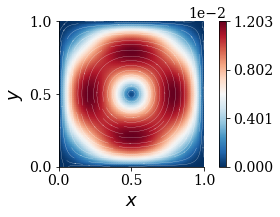

In [29]:
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

x = torch.linspace(0,1,64)
y = torch.linspace(0,1,64)

x,y = torch.meshgrid(x,y,indexing='xy')

u,v,_,_ = model(x.reshape(-1,1),y.reshape(-1,1))

u   = u.reshape(x.shape)
v   = v.reshape(x.shape)

vel_pred = (u.pow(2) + v.pow(2)).detach().sqrt()
vmax = torch.max(vel_pred)
vmin = torch.min(vel_pred)

img = ax.pcolormesh(x.numpy(),y.numpy(),vel_pred,vmin=vmin,vmax=vmax,shading='gouraud',cmap=cmap)
colorbar(img,vmin,vmax,limit=0)

img=ax.streamplot(x.numpy(),y.numpy(),
                  u.detach().numpy(),
                  v.detach().numpy(),
                  density=1,
                  arrowsize=0.2,
                  arrowstyle='->',
                  color='w',
                  linewidth=0.2,
                  cmap=cmap)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/predicted_stokes_velocity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

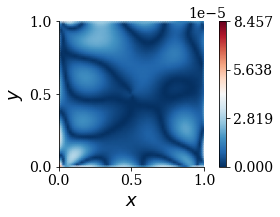

In [30]:
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

error = abs(vel_exact - vel_pred.numpy())
vmax = np.amax(error)
vmin = np.amin(error)

img = ax.pcolormesh(x.numpy(),y.numpy(),error,vmin=vmin,vmax=vmax,shading='gouraud',cmap=cmap)
colorbar(img,vmin,vmax,limit=0)

ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/error_stokes_velocity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

In [31]:
l2_vel = np.linalg.norm(vel_exact-vel_pred.numpy(), 2)/np.linalg.norm(vel_exact, 2)
print(f'l2 vel: {l2_vel:2.3e}')

l2 vel: 1.050e-03


In [32]:
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

x = torch.linspace(0,1,64)
y = torch.linspace(0,1,64)

x,y = torch.meshgrid(x,y,indexing='ij')

x_,y_ = x.reshape(-1,1),y.reshape(-1,1)


pe = p_exact(x,y)
we = w_exact(x,y)

u,v,p,w = model(x_,y_)

p = p.detach().reshape(x.shape)
w = w.detach().reshape(x.shape)


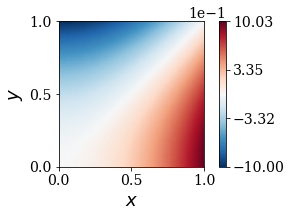

In [33]:
#----- predicted pressure 
plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])


vmax = torch.max(p)
vmin = torch.min(p)

img = ax.pcolormesh(x,y,p,shading='gouraud',cmap=cmap,vmin=vmin,vmax=vmax)
colorbar(img,vmin,vmax,limit=-1)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
plt.savefig('figures/predicted_stokes_pressure_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

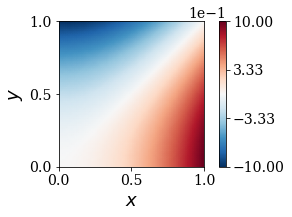

In [35]:
#----- exact pressure 
plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])


vmax = torch.max(pe)
vmin = torch.min(pe)

img = ax.pcolormesh(x,y,pe,shading='gouraud',cmap=cmap,vmin=vmin,vmax=vmax)
colorbar(img,vmin,vmax,limit=-1)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
plt.savefig('figures/exact_stokes_pressure_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

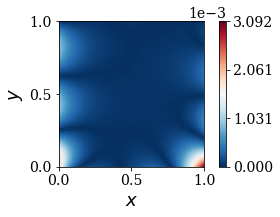

In [36]:
#----- error pressure 
plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

error = abs(pe - p)

vmax = torch.max(error)
vmin = torch.min(error)

img = ax.pcolormesh(x,y,error,shading='gouraud',cmap=cmap,vmin=vmin,vmax=vmax)
colorbar(img,vmin,vmax,limit=-3)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
plt.savefig('figures/error_stokes_pressure_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

In [37]:
l2_p = np.linalg.norm(p-pe, 2)/np.linalg.norm(pe, 2)
print(f'l2p: {l2_p:2.3e}')

l2p: 9.952e-04


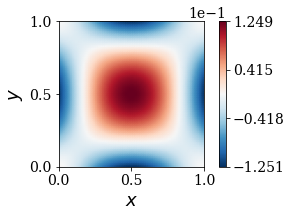

In [38]:
#----- predicted vorticity 
plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])


vmax = torch.max(w)
vmin = torch.min(w)

img = ax.pcolormesh(x,y,w,shading='gouraud',cmap=cmap,vmin=vmin,vmax=vmax)
colorbar(img,vmin,vmax,limit=-1)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
plt.savefig('figures/predicted_stokes_vorticity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

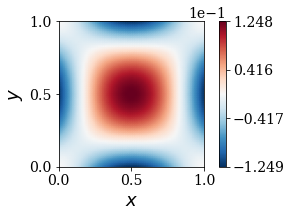

In [39]:
#----- exact vorticity 
plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])


vmax = torch.max(we)
vmin = torch.min(we)

img = ax.pcolormesh(x,y,we,shading='gouraud',cmap=cmap,vmin=vmin,vmax=vmax)
colorbar(img,vmin,vmax,limit=-1)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
plt.savefig('figures/exact_stokes_vorticity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

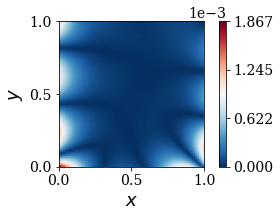

In [40]:
#----- error vorticity 

plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])

error = abs(we - w)

vmax = torch.max(error)
vmin = torch.min(error)

img = ax.pcolormesh(x,y,error,shading='gouraud',cmap=cmap,vmin=vmin,vmax=vmax)
colorbar(img,vmin,vmax,limit=-3)
ax.axis('square')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))
plt.savefig('figures/error_stokes_vorticity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

In [41]:
l2_w = np.linalg.norm(w-we, 2)/np.linalg.norm(we, 2)
print(f'l2 w: {l2_w:2.3e}')

l2 w: 4.052e-03
